In [19]:
import pandas as pd
from cobra.io import load_json_model

In [20]:
df_meas = pd.read_csv('data/flux_intra_glucose_pcfba_R02.csv')
df_meas = df_meas[ df_meas.flux.abs()<500]
df_meas = df_meas[ df_meas.flux.abs()>5e-1]
df_meas = df_meas[['rxn','vmeas']]

In [21]:
model = load_json_model('../data/models/json/iJO1366.json')

In [22]:
model.optimize()

<Solution 0.98 at 0x7f8e0d2a44d0>

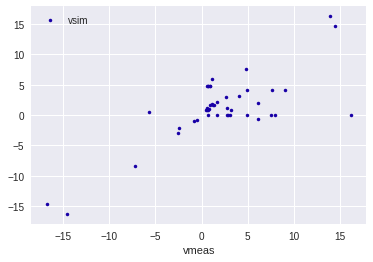

In [23]:
import seaborn as sns
%matplotlib inline

df_sim = pd.DataFrame([{'rxn':r.id, 'vsim':r.x} for r in model.reactions])
df_val = pd.merge(df_meas, df_sim, on='rxn')
df_val0 = pd.merge(df_meas, df_sim, on='rxn')
df_val[df_val.vsim.abs()<100].plot('vmeas','vsim', linestyle='None', marker='.')

\begin{align}
\min_{v,e}   \quad & c^T v + e^T Q e \\
\mathrm{s.t} \quad & Sv = 0 \\
                   & l \leq v \leq u \\
                   & e_j - v_j = - v^*_j \quad j\in Meas
\end{align}

In [24]:
from cobra import Metabolite, Reaction

class Variable(Reaction):
    pass

class Constraint(Metabolite):
    pass

In [25]:
model = load_json_model('../data/models/json/iJO1366.json')

for i,row in df_val.iterrows():
    vmeas = row['vmeas']
    rxn = model.reactions.get_by_id(row['rxn'])
    e = Variable('err_%s'%rxn.id)
    e.lower_bound = -1e6
    e.upper_bound = 1e6
    model.add_reaction(e)
    
    cons = Constraint('cons_err_%s'%rxn.id)
    cons._bound = -vmeas
    cons._constraint_sense = 'E'
    model.add_metabolites(cons)
    
    e.add_metabolites({cons:1.})
    rxn.add_metabolites({cons:-1.})

for rxn in model.reactions:
    rxn.objective_coefficient = 0

from scipy.sparse import dok_matrix

n = len(model.reactions)
Q = dok_matrix((n,n))

for e in model.reactions.query('err_'):
    ind = model.reactions.index(e)
    Q[ind,ind] = 1.

In [26]:
model.optimize('minimize', quadratic_component=Q, solver='gurobi')

<Solution 5.54 at 0x7f8e02825190>

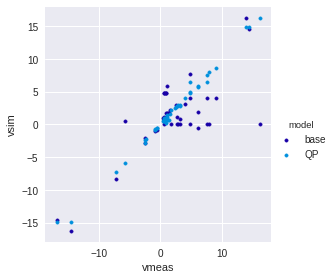

In [27]:
import seaborn as sns
%matplotlib inline

df_sim = pd.DataFrame([{'rxn':r.id, 'vsim':r.x} for r in model.reactions])
df_val = pd.merge(df_meas, df_sim, on='rxn')
# df_val[df_val.vsim.abs()<100].plot('vmeas','vsim', linestyle='None', marker='.')
df_val.loc[:,'model'] = 'QP'
df_val0.loc[:,'model'] = 'base'

df_val2 = pd.concat([df_val0, df_val])

import matplotlib.pyplot as plt
sns.set_palette('nipy_spectral')
g = sns.FacetGrid(df_val2[df_val2.vsim.abs()<100], hue='model', size=4)
g.map(plt.scatter, 'vmeas', 'vsim', s=12)
g.add_legend()

---

\begin{align}
\min_{v,e,y}   \quad & e^T Q e \\
\mathrm{s.t} \quad & Sv = 0 \\
                   & l \leq v \leq u \\
                   & e_j - v_j = - v^*_j, \quad j\in Meas \\
                   & -M y_j - \epsilon \leq v_j - v^r_j \leq M y_j + \epsilon,  \quad j\in Meas \\
                   & \sum_j y_j \leq K \\
                   & y \in \{0,1\}
\end{align}

In [28]:
M = 1e3
EPSILON = 1e-5
K = 10

In [29]:
model_ref = load_json_model('../data/models/json/iJO1366.json')
model_ref.optimize()

<Solution 0.98 at 0x7f8df3a71490>

In [30]:
model = load_json_model('../data/models/json/iJO1366.json')

for i,row in df_val.iterrows():
    vmeas = row['vmeas']
    rxn = model.reactions.get_by_id(row['rxn'])
    e = Variable('err_%s'%rxn.id)
    e.lower_bound = -1e6
    e.upper_bound = 1e6
    model.add_reaction(e)
    
    cons = Constraint('cons_err_%s'%rxn.id)
    cons._bound = -vmeas
    cons._constraint_sense = 'E'
    model.add_metabolites(cons)
    
    e.add_metabolites({cons:1.})
    rxn.add_metabolites({cons:-1.})

for rxn in model.reactions:
    rxn.objective_coefficient = 0

from scipy.sparse import dok_matrix

n = len(model.reactions)
Q = dok_matrix((n,n))

for e in model.reactions.query('err_'):
    ind = model.reactions.index(e)
    Q[ind,ind] = 1.
    
    
### LOOK HERE FIRST IF INFEASIBLE
# v - vref <= M * y + eps
# v - M*y <= vref + eps
#
# -M * y -eps <= v - vref
# v + M*y >= vref - eps

for i,row in df_val.iterrows():
    rxn = model.reactions.get_by_id(row['rxn'])
    y = Variable('binary_%s'%rxn.id)
    y.upper_bound = 1.
    y.lower_bound = 0.
    y.variable_kind = 'integer'
    model.add_reaction(y)
    
    vref = model_ref.reactions.get_by_id(rxn.id).x
    
    cons_u = Constraint('cons_dev_u_%s'%rxn.id)
    cons_u._constraint_sense = 'L'
    cons_u._bound = vref + EPSILON
    model.add_metabolites(cons_u)
    
    cons_l = Constraint('cons_dev_l_%s'%rxn.id)
    cons_l._constraint_sense = 'G'
    cons_l._bound = vref - EPSILON
    model.add_metabolites(cons_l)

    # v - M*y <= vref + eps
    rxn.add_metabolites({cons_u:1.})
    y.add_metabolites({cons_u:-M})
    
    # v + M*y >= vref - eps
    rxn.add_metabolites({cons_l:1.})
    y.add_metabolites({cons_l:M})
    
# sum_y <= K
cons_max_bin = Metabolite('cons_max_bin')
cons_max_bin._bound = K
cons_max_bin._constraint_sense = 'L'
model.add_metabolites(cons_max_bin)

for y in model.reactions.query('binary_'):
    y.add_metabolites({cons_max_bin:1.})

In [31]:
N_MEAS = len(df_val.rxn.unique())
N_MEAS

51

In [44]:
# Make growth an objective, but weighted smaller than the error minimization
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = -1

for K in range(1,20, 5):
    cons_max_bin._bound = K
    model.optimize('minimize', quadratic_component=Q, solver='gurobi')
    objval = model.solution.f
    muopt = model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    print("K=%d. objval=%g. mu=%g."%(K, objval, muopt))

K=1. objval=1.4925e+06. mu=0.98236.
K=6. objval=194.189. mu=0.797651.
K=11. objval=101.018. mu=0.171966.
K=16. objval=59.096. mu=0.327435.


In [45]:
n_changed_fluxes = sum([y.x for y in model.reactions.query('binary_')])
print(n_changed_fluxes)

16.0


In [46]:
[(y.id,y.x) for y in model.reactions.query('binary_') if y.x > 0.5]

[(u'binary_ACKr', 1.0),
 (u'binary_ACONTa', 1.0),
 (u'binary_ACONTb', 1.0),
 (u'binary_ADK1', 1.0),
 (u'binary_ADK3', 1.0),
 (u'binary_ALATA_L', 1.0),
 (u'binary_CS', 1.0),
 (u'binary_DHAPT', 1.0),
 (u'binary_FUM', 1.0),
 (u'binary_ICDHyr', 1.0),
 (u'binary_NADH5', 1.0),
 (u'binary_NADPHQR2', 1.0),
 (u'binary_PFL', 1.0),
 (u'binary_PGI', 1.0),
 (u'binary_PPKr', 1.0),
 (u'binary_PTAr', 1.0)]